<a href="https://colab.research.google.com/github/ShriyaGandotra/Intro-to-Deep-Learning/blob/main/HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive/Real Time ML/Assignment 1')

Mounted at /content/gdrive


Files already downloaded and verified
Files already downloaded and verified
Epoch 1/20, Loss: 2.0677, Validation Loss: 1.8440, Training Accuracy: 0.2630, Validation Accuracy: 0.3519
Epoch 2/20, Loss: 1.7298, Validation Loss: 1.6384, Training Accuracy: 0.3870, Validation Accuracy: 0.4233
Epoch 3/20, Loss: 1.5849, Validation Loss: 1.5407, Training Accuracy: 0.4395, Validation Accuracy: 0.4520
Epoch 4/20, Loss: 1.4875, Validation Loss: 1.4783, Training Accuracy: 0.4746, Validation Accuracy: 0.4806
Epoch 5/20, Loss: 1.4094, Validation Loss: 1.4743, Training Accuracy: 0.5033, Validation Accuracy: 0.4793
Epoch 6/20, Loss: 1.3445, Validation Loss: 1.4069, Training Accuracy: 0.5275, Validation Accuracy: 0.5042
Epoch 7/20, Loss: 1.2884, Validation Loss: 1.4243, Training Accuracy: 0.5487, Validation Accuracy: 0.4968
Epoch 8/20, Loss: 1.2359, Validation Loss: 1.3672, Training Accuracy: 0.5671, Validation Accuracy: 0.5206
Epoch 9/20, Loss: 1.1892, Validation Loss: 1.4246, Training Accuracy: 0.5830

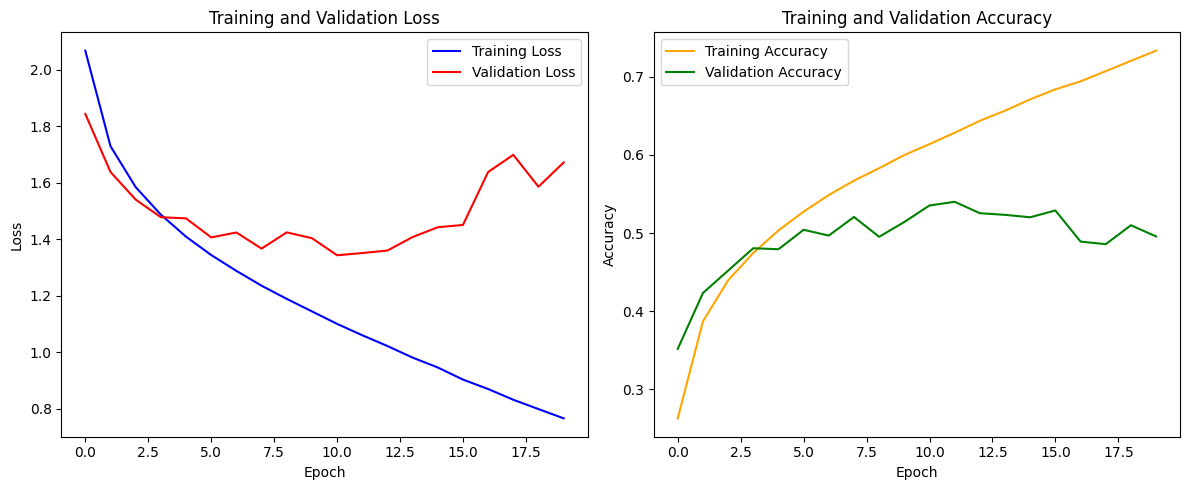

Precision: 0.5218, Recall: 0.4957, F1 Score: 0.4925


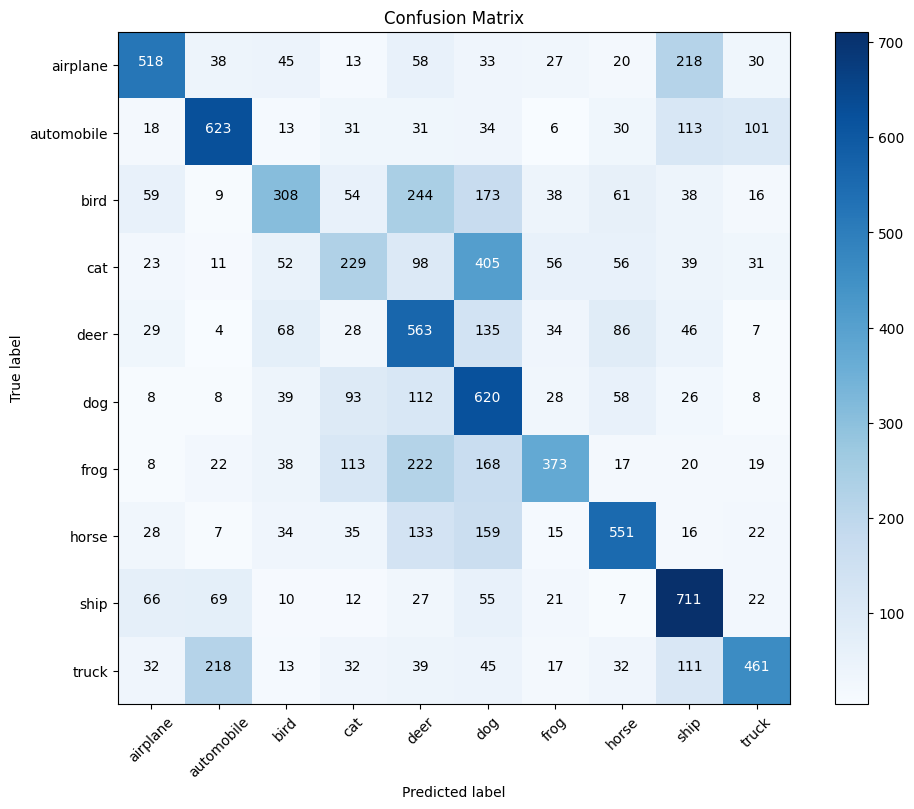

In [8]:
################################# Problem 1 A ####################################
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import itertools
import time

# Load CIFAR-10 dataset
data_path = '../data-unversioned/p1ch7/'  # Modify this path according to the data location
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))
])
cifar10 = datasets.CIFAR10(data_path, train=True, download=True, transform=transform)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True, transform=transform)

train_loader = DataLoader(cifar10, batch_size=64, shuffle=True)
val_loader = DataLoader(cifar10_val, batch_size=64, shuffle=False)

# Define the MLP model with three hidden layers using nn.Sequential
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3*32*32, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

# Training
learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()
n_epochs = 20

training_losses = []
training_accuracies = []
validation_accuracies = []
validation_losses = []

start_time = time.time()

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for imgs, labels in train_loader:
        outputs = model(imgs)
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    training_losses.append(running_loss / len(train_loader))
    training_accuracies.append(correct / total)

    val_loss = 0.0
    with torch.no_grad():
        for imgs, labels in val_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
    validation_losses.append(val_loss / len(val_loader))

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            outputs = model(imgs)
            _, predicted = torch.max(outputs, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    validation_accuracy = correct / total
    validation_accuracies.append(validation_accuracy)

    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {running_loss/len(train_loader):.4f}, "
          f"Validation Loss: {validation_losses[-1]:.4f}, "
          f"Training Accuracy: {training_accuracies[-1]:.4f}, "
          f"Validation Accuracy: {validation_accuracy:.4f}")

end_time = time.time()
print(f"Total training time: {end_time - start_time:.2f}s")
print(f"Final Validation Accuracy: {validation_accuracies[-1]:.4f}")

# Plotting Training Loss and Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(training_losses, label='Training Loss', color ='blue')
plt.plot(validation_losses, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training_accuracies, label='Training Accuracy', color='orange')
plt.plot(validation_accuracies, label='Validation Accuracy', color='green')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation Metrics
def evaluate_model(model, data_loader):
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for imgs, labels in data_loader:
            outputs = model(imgs)
            _, predicted = torch.max(outputs, dim=1)
            y_true.extend(labels.tolist())
            y_pred.extend(predicted.tolist())
    return y_true, y_pred

y_true, y_pred = evaluate_model(model, val_loader)

precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}")

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plotting the confusion matrix
class_names = cifar10.classes
plt.figure(figsize=(10, 8))
plot_confusion_matrix(conf_matrix, classes=class_names, title='Confusion Matrix')
plt.show()


Files already downloaded and verified
Files already downloaded and verified
Epoch 1/20, Loss: 2.2981, Validation Loss: 2.2864, Training Accuracy: 0.1232, Validation Accuracy: 0.1891
Epoch 2/20, Loss: 2.2019, Validation Loss: 2.0204, Training Accuracy: 0.2073, Validation Accuracy: 0.2636
Epoch 3/20, Loss: 1.9140, Validation Loss: 1.8229, Training Accuracy: 0.2923, Validation Accuracy: 0.3329
Epoch 4/20, Loss: 1.7604, Validation Loss: 1.7195, Training Accuracy: 0.3575, Validation Accuracy: 0.3614
Epoch 5/20, Loss: 1.6405, Validation Loss: 1.6217, Training Accuracy: 0.4046, Validation Accuracy: 0.4136
Epoch 6/20, Loss: 1.5384, Validation Loss: 1.5386, Training Accuracy: 0.4439, Validation Accuracy: 0.4533
Epoch 7/20, Loss: 1.4507, Validation Loss: 1.5921, Training Accuracy: 0.4772, Validation Accuracy: 0.4456
Epoch 8/20, Loss: 1.3788, Validation Loss: 1.5944, Training Accuracy: 0.5057, Validation Accuracy: 0.4419
Epoch 9/20, Loss: 1.3146, Validation Loss: 1.4678, Training Accuracy: 0.5280

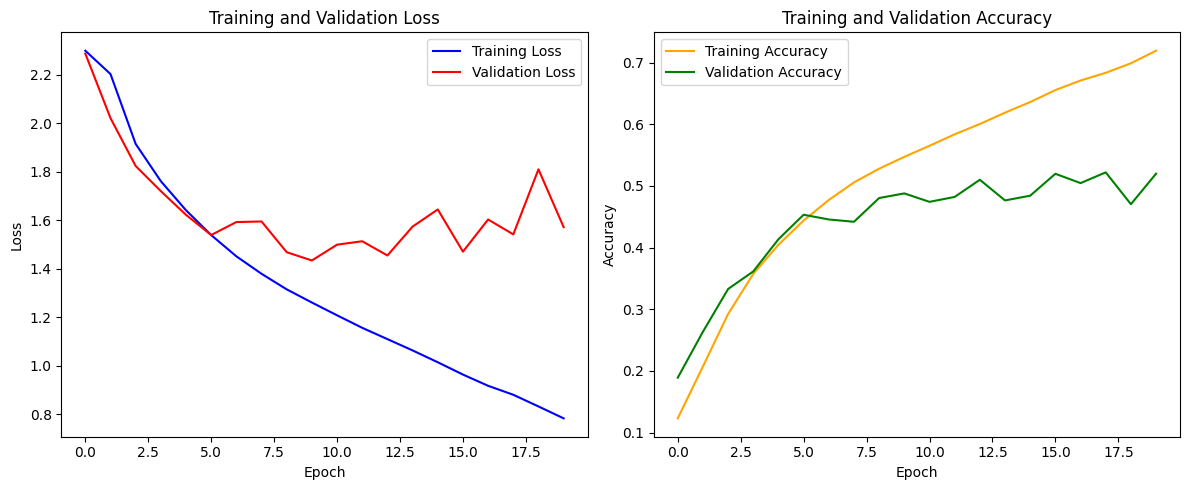

Precision: 0.5297, Recall: 0.5199, F1 Score: 0.5156


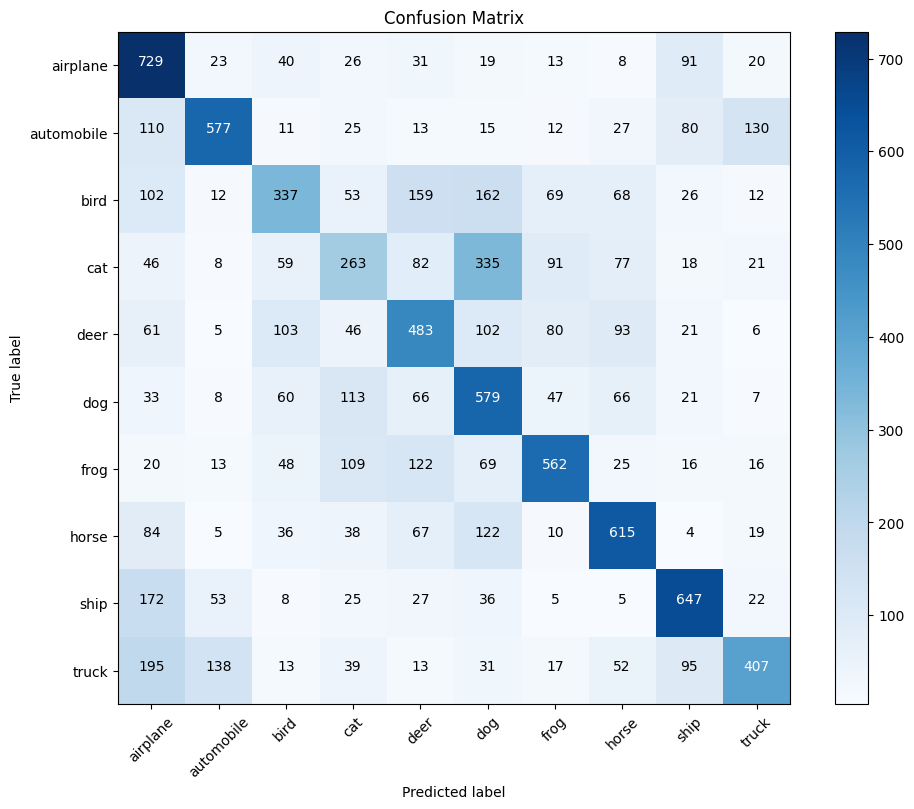

In [9]:
################################# Problem 1 B ####################################
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import itertools
import time

# Load CIFAR-10 dataset
data_path = '../data-unversioned/p1ch7/'  # Modify this path according to the data location
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))
])
cifar10 = datasets.CIFAR10(data_path, train=True, download=True, transform=transform)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True, transform=transform)

train_loader = DataLoader(cifar10, batch_size=64, shuffle=True)
val_loader = DataLoader(cifar10_val, batch_size=64, shuffle=False)

# Define the MLP model with three hidden layers using nn.Sequential
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3*32*32, 1024),  # Increased width
    nn.ReLU(),
    nn.Linear(1024, 512),      # Increased width
    nn.ReLU(),
    nn.Linear(512, 256),       # Increased width
    nn.ReLU(),
    nn.Linear(256, 128),       # Same as before
    nn.ReLU(),
    nn.Linear(128, 64),        # Additional layer (increased depth)
    nn.ReLU(),
    nn.Linear(64, 10)          # Output layer
)

# Training
learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()
n_epochs = 20

training_losses = []
training_accuracies = []
validation_accuracies = []
validation_losses = []

start_time = time.time()

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for imgs, labels in train_loader:
        outputs = model(imgs)
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    training_losses.append(running_loss / len(train_loader))
    training_accuracies.append(correct / total)

    val_loss = 0.0
    with torch.no_grad():
        for imgs, labels in val_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
    validation_losses.append(val_loss / len(val_loader))

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            outputs = model(imgs)
            _, predicted = torch.max(outputs, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    validation_accuracy = correct / total
    validation_accuracies.append(validation_accuracy)

    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {running_loss/len(train_loader):.4f}, "
          f"Validation Loss: {validation_losses[-1]:.4f}, "
          f"Training Accuracy: {training_accuracies[-1]:.4f}, "
          f"Validation Accuracy: {validation_accuracy:.4f}")

end_time = time.time()
print(f"Total training time: {end_time - start_time:.2f}s")
print(f"Final Validation Accuracy: {validation_accuracies[-1]:.4f}")

# Plotting Training Loss and Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(training_losses, label='Training Loss', color ='blue')
plt.plot(validation_losses, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training_accuracies, label='Training Accuracy', color='orange')
plt.plot(validation_accuracies, label='Validation Accuracy', color='green')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation Metrics
def evaluate_model(model, data_loader):
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for imgs, labels in data_loader:
            outputs = model(imgs)
            _, predicted = torch.max(outputs, dim=1)
            y_true.extend(labels.tolist())
            y_pred.extend(predicted.tolist())
    return y_true, y_pred

y_true, y_pred = evaluate_model(model, val_loader)

precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}")

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plotting the confusion matrix
class_names = cifar10.classes
plt.figure(figsize=(10, 8))
plot_confusion_matrix(conf_matrix, classes=class_names, title='Confusion Matrix')
plt.show()

Epoch 10/100, Train RMSE: 101586.10, Validation RMSE: 91217.48
Epoch 20/100, Train RMSE: 70197.15, Validation RMSE: 62886.00
Epoch 30/100, Train RMSE: 58280.27, Validation RMSE: 52412.15
Epoch 40/100, Train RMSE: 48622.66, Validation RMSE: 44045.11
Epoch 50/100, Train RMSE: 42351.77, Validation RMSE: 40014.70
Epoch 60/100, Train RMSE: 38803.73, Validation RMSE: 37521.78
Epoch 70/100, Train RMSE: 36632.93, Validation RMSE: 36358.61
Epoch 80/100, Train RMSE: 35247.18, Validation RMSE: 35848.78
Epoch 90/100, Train RMSE: 34271.65, Validation RMSE: 35432.52
Epoch 100/100, Train RMSE: 33614.52, Validation RMSE: 35035.58
Final RMSE on Training Set: 33614.52
Final RMSE on Validation Set: 35035.58
Final R2 Score on Validation Set: 0.84


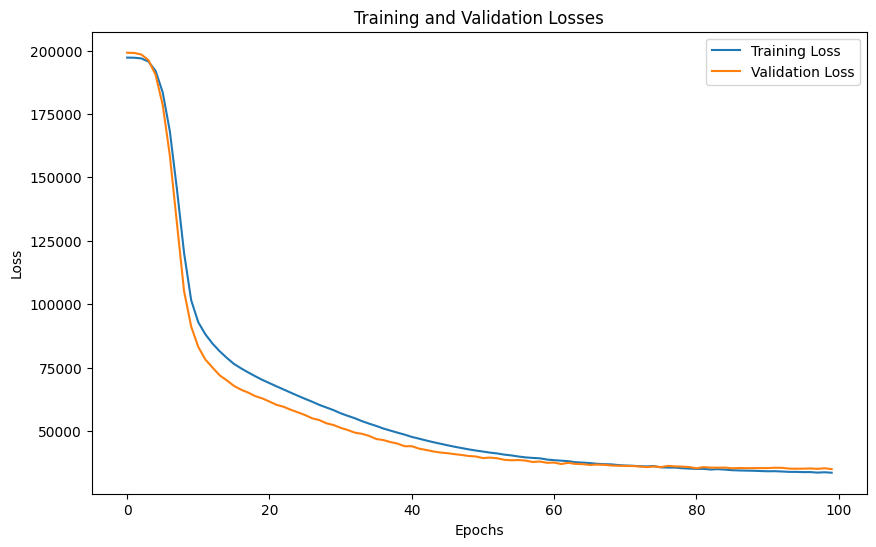

In [4]:
################################# Problem 2 A ####################################
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import r2_score
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Load the datasets
df_train = pd.read_csv('house-train.csv')
df_test = pd.read_csv('house-test.csv')

# Specified useful columns
useful_cols = ['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF',
               'FullBath', 'YearBuilt', 'YearRemodAdd', 'Fireplaces',
               'LotFrontage', 'WoodDeckSF', 'OpenPorchSF',
               'ExterQual', 'Neighborhood', 'MSZoning',
               'Alley', 'LotShape', 'LandContour', 'Condition1', 'HouseStyle',
               'MasVnrType', 'SaleCondition']

# Preprocessing as specified
df_train_prepro = df_train[useful_cols + ['SalePrice']].copy()
df_test_prepro = df_test[useful_cols].copy()

# Fill missing values in GarageArea and TotalBsmtSF for test data
df_test_prepro['GarageArea'] = df_test_prepro['GarageArea'].fillna(df_train_prepro['GarageArea'].mean())
df_test_prepro['TotalBsmtSF'] = df_test_prepro['TotalBsmtSF'].fillna(df_train_prepro['TotalBsmtSF'].mean())

# Label Encoding for categorical features
for col in df_train_prepro.columns:
    if df_train_prepro[col].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(df_train_prepro[col].values) + list(df_test_prepro[col].values))
        df_train_prepro[col] = lbl.transform(list(df_train_prepro[col].values))
        df_test_prepro[col] = lbl.transform(list(df_test_prepro[col].values))

# Handling missing values in training data
df_train_prepro = df_train_prepro.fillna(df_train_prepro.mean())

# Splitting the dataset into training and validation sets
X = df_train_prepro.drop('SalePrice', axis=1)
y = df_train_prepro['SalePrice']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Converting data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

# Creating datasets and dataloaders for training and validation
train_data = TensorDataset(X_train_tensor, y_train_tensor)
val_data = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

# Define the MLP model with three hidden layers
model = nn.Sequential(
    nn.Linear(X_train.shape[1], 128),  # 1st hidden layer with 128 neurons
    nn.ReLU(),
    nn.Linear(128, 64),  # 2nd hidden layer with 64 neurons
    nn.ReLU(),
    nn.Linear(64, 32),   # 3rd hidden layer with 32 neurons
    nn.ReLU(),
    nn.Linear(32, 1)     # Output layer
)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100):
    train_rmse, val_rmse, val_r2 = [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_rmse.append(np.sqrt(epoch_loss))

        model.eval()
        with torch.no_grad():
            running_val_loss = 0.0
            val_targets = []
            val_outputs = []
            for inputs, targets in val_loader:
                outputs = model(inputs)
                val_loss = criterion(outputs.squeeze(), targets)
                running_val_loss += val_loss.item() * inputs.size(0)
                val_targets.extend(targets.numpy())
                val_outputs.extend(outputs.numpy().squeeze())

            epoch_val_loss = running_val_loss / len(val_loader.dataset)
            val_rmse.append(np.sqrt(epoch_val_loss))
            r2 = r2_score(val_targets, val_outputs)
            val_r2.append(r2)

        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Train RMSE: {np.sqrt(epoch_loss):.2f}, Validation RMSE: {np.sqrt(epoch_val_loss):.2f}')

    return train_rmse, val_rmse, val_r2

# Train the model
num_epochs = 100
train_rmse, val_rmse, val_r2 = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

# Print the final RMSE on Training and Validation Sets
print(f"Final RMSE on Training Set: {train_rmse[-1]:.2f}")
print(f"Final RMSE on Validation Set: {val_rmse[-1]:.2f}")
print(f"Final R2 Score on Validation Set: {val_r2[-1]:.2f}")

# Plotting training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), train_rmse, label='Training Loss')
plt.plot(range(num_epochs), val_rmse, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Epoch 10/100, Train RMSE: 86373.62, Validation RMSE: 78879.46
Epoch 20/100, Train RMSE: 44438.58, Validation RMSE: 44710.35
Epoch 30/100, Train RMSE: 37238.50, Validation RMSE: 40155.37
Epoch 40/100, Train RMSE: 33052.24, Validation RMSE: 37882.58
Epoch 50/100, Train RMSE: 30259.72, Validation RMSE: 36200.00
Epoch 60/100, Train RMSE: 28329.78, Validation RMSE: 35305.78
Epoch 70/100, Train RMSE: 26911.81, Validation RMSE: 34675.93
Epoch 80/100, Train RMSE: 25716.52, Validation RMSE: 34121.56
Epoch 90/100, Train RMSE: 24769.08, Validation RMSE: 33593.23
Epoch 100/100, Train RMSE: 23942.49, Validation RMSE: 33114.90
Final RMSE on Training Set: 23942.49
Final RMSE on Validation Set: 33114.90
Final R2 Score on Validation Set: 0.86


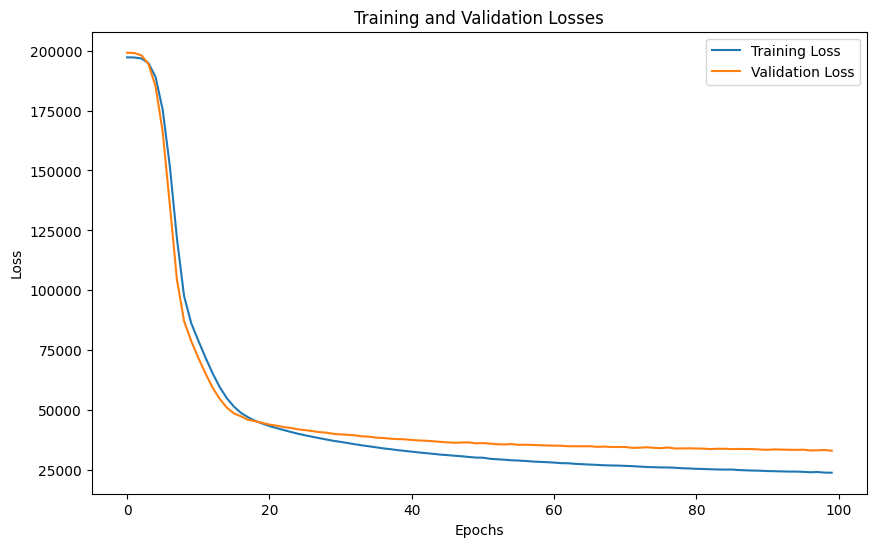

In [5]:
################################# Problem 2 B ####################################
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Load the datasets
df_train = pd.read_csv('house-train.csv')
df_test = pd.read_csv('house-test.csv')

# Specified useful columns
useful_cols = ['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF',
               'FullBath', 'YearBuilt', 'YearRemodAdd', 'Fireplaces',
               'LotFrontage', 'WoodDeckSF', 'OpenPorchSF',
               'ExterQual', 'Neighborhood', 'MSZoning',
               'Alley', 'LotShape', 'LandContour', 'Condition1', 'HouseStyle',
               'MasVnrType', 'SaleCondition']

# Preprocessing as specified
df_train_prepro = df_train[useful_cols + ['SalePrice']].copy()
df_test_prepro = df_test[useful_cols].copy()

# Fill missing values in GarageArea and TotalBsmtSF for test data
df_test_prepro['GarageArea'] = df_test_prepro['GarageArea'].fillna(df_train_prepro['GarageArea'].mean())
df_test_prepro['TotalBsmtSF'] = df_test_prepro['TotalBsmtSF'].fillna(df_train_prepro['TotalBsmtSF'].mean())

# One-hot encoding for categorical features
categorical_cols = ['ExterQual', 'Neighborhood', 'MSZoning',
                    'Alley', 'LotShape', 'LandContour', 'Condition1', 'HouseStyle',
                    'MasVnrType', 'SaleCondition']

for col in categorical_cols:
    df_train_prepro = pd.get_dummies(df_train_prepro, columns=[col], prefix=[col])
    df_test_prepro = pd.get_dummies(df_test_prepro, columns=[col], prefix=[col])

# Handling missing values in training data
df_train_prepro = df_train_prepro.fillna(df_train_prepro.mean())

# Splitting the dataset into training and validation sets
X = df_train_prepro.drop('SalePrice', axis=1)
y = df_train_prepro['SalePrice']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Converting data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

# Creating datasets and dataloaders for training and validation
train_data = TensorDataset(X_train_tensor, y_train_tensor)
val_data = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

# Define the MLP model with three hidden layers
model = nn.Sequential(
    nn.Linear(X_train.shape[1], 128),  # 1st hidden layer with 128 neurons
    nn.ReLU(),
    nn.Linear(128, 64),  # 2nd hidden layer with 64 neurons
    nn.ReLU(),
    nn.Linear(64, 32),   # 3rd hidden layer with 32 neurons
    nn.ReLU(),
    # nn.Dropout(0.1),  # Add dropout
    nn.Linear(32, 1)     # Output layer
)


# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100):
    train_rmse, val_rmse, val_r2 = [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_rmse.append(np.sqrt(epoch_loss))

        model.eval()
        with torch.no_grad():
            running_val_loss = 0.0
            val_targets = []
            val_outputs = []
            for inputs, targets in val_loader:
                outputs = model(inputs)
                val_loss = criterion(outputs.squeeze(), targets)
                running_val_loss += val_loss.item() * inputs.size(0)
                val_targets.extend(targets.numpy())
                val_outputs.extend(outputs.numpy().squeeze())

            epoch_val_loss = running_val_loss / len(val_loader.dataset)
            val_rmse.append(np.sqrt(epoch_val_loss))
            r2 = r2_score(val_targets, val_outputs)
            val_r2.append(r2)

        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Train RMSE: {np.sqrt(epoch_loss):.2f}, Validation RMSE: {np.sqrt(epoch_val_loss):.2f}')

    return train_rmse, val_rmse, val_r2

# Train the model
num_epochs = 100
train_rmse, val_rmse, val_r2 = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

# Print the final RMSE on Training and Validation Sets
print(f"Final RMSE on Training Set: {train_rmse[-1]:.2f}")
print(f"Final RMSE on Validation Set: {val_rmse[-1]:.2f}")
print(f"Final R2 Score on Validation Set: {val_r2[-1]:.2f}")

# Plotting training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), train_rmse, label='Training Loss')
plt.plot(range(num_epochs), val_rmse, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Epoch 10/100, Train RMSE: 190630.12, Validation RMSE: 189873.50
Epoch 20/100, Train RMSE: 69146.60, Validation RMSE: 64376.34
Epoch 30/100, Train RMSE: 41893.19, Validation RMSE: 41378.03
Epoch 40/100, Train RMSE: 36233.28, Validation RMSE: 38215.25
Epoch 50/100, Train RMSE: 33409.61, Validation RMSE: 36608.80
Epoch 60/100, Train RMSE: 31290.05, Validation RMSE: 35470.96
Epoch 70/100, Train RMSE: 29664.03, Validation RMSE: 34451.65
Epoch 80/100, Train RMSE: 28276.99, Validation RMSE: 33772.29
Epoch 90/100, Train RMSE: 27113.93, Validation RMSE: 33296.06
Epoch 100/100, Train RMSE: 26138.83, Validation RMSE: 32841.10
Final RMSE on Training Set: 26138.83
Final RMSE on Validation Set: 32841.10
Final R2 Score on Validation Set: 0.86


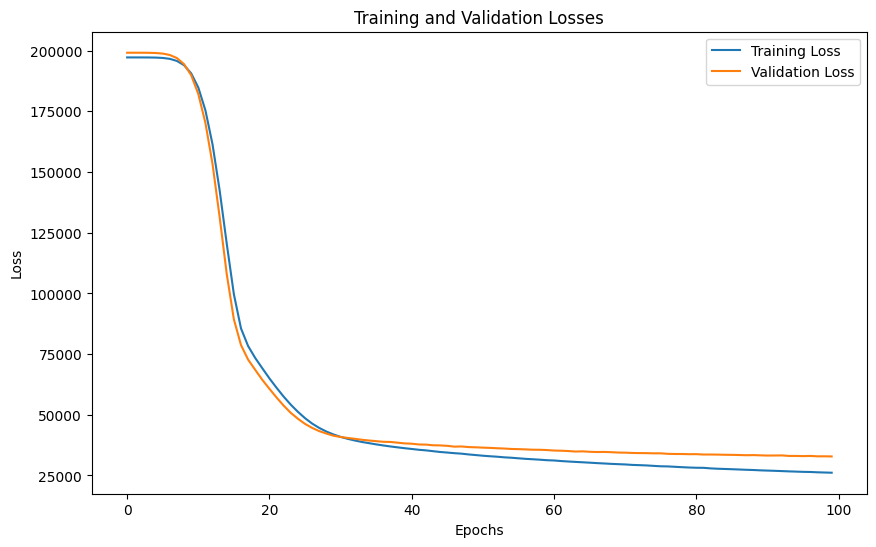

In [6]:
################################# Problem 2 C ####################################
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Load the datasets
df_train = pd.read_csv('house-train.csv')
df_test = pd.read_csv('house-test.csv')

# Specified useful columns
useful_cols = ['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF',
               'FullBath', 'YearBuilt', 'YearRemodAdd', 'Fireplaces',
               'LotFrontage', 'WoodDeckSF', 'OpenPorchSF',
               'ExterQual', 'Neighborhood', 'MSZoning',
               'Alley', 'LotShape', 'LandContour', 'Condition1', 'HouseStyle',
               'MasVnrType', 'SaleCondition']

# Preprocessing as specified
df_train_prepro = df_train[useful_cols + ['SalePrice']].copy()
df_test_prepro = df_test[useful_cols].copy()

# Fill missing values in GarageArea and TotalBsmtSF for test data
df_test_prepro['GarageArea'] = df_test_prepro['GarageArea'].fillna(df_train_prepro['GarageArea'].mean())
df_test_prepro['TotalBsmtSF'] = df_test_prepro['TotalBsmtSF'].fillna(df_train_prepro['TotalBsmtSF'].mean())

# One-hot encoding for categorical features
categorical_cols = ['ExterQual', 'Neighborhood', 'MSZoning',
                    'Alley', 'LotShape', 'LandContour', 'Condition1', 'HouseStyle',
                    'MasVnrType', 'SaleCondition']

for col in categorical_cols:
    df_train_prepro = pd.get_dummies(df_train_prepro, columns=[col], prefix=[col])
    df_test_prepro = pd.get_dummies(df_test_prepro, columns=[col], prefix=[col])

# Handling missing values in training data
df_train_prepro = df_train_prepro.fillna(df_train_prepro.mean())

# Splitting the dataset into training and validation sets
X = df_train_prepro.drop('SalePrice', axis=1)
y = df_train_prepro['SalePrice']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Converting data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

# Creating datasets and dataloaders for training and validation
train_data = TensorDataset(X_train_tensor, y_train_tensor)
val_data = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

model = nn.Sequential(
    nn.Linear(X_train.shape[1], 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 1)
)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training the model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100):
    train_rmse, val_rmse, val_r2 = [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_rmse.append(np.sqrt(epoch_loss))

        model.eval()
        with torch.no_grad():
            running_val_loss = 0.0
            val_targets = []
            val_outputs = []
            for inputs, targets in val_loader:
                outputs = model(inputs)
                val_loss = criterion(outputs.squeeze(), targets)
                running_val_loss += val_loss.item() * inputs.size(0)
                val_targets.extend(targets.numpy())
                val_outputs.extend(outputs.numpy().squeeze())

            epoch_val_loss = running_val_loss / len(val_loader.dataset)
            val_rmse.append(np.sqrt(epoch_val_loss))
            r2 = r2_score(val_targets, val_outputs)
            val_r2.append(r2)

        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Train RMSE: {np.sqrt(epoch_loss):.2f}, Validation RMSE: {np.sqrt(epoch_val_loss):.2f}')

    return train_rmse, val_rmse, val_r2

# Train the model
num_epochs = 100
train_rmse, val_rmse, val_r2 = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

# Print the final RMSE on Training and Validation Sets
print(f"Final RMSE on Training Set: {train_rmse[-1]:.2f}")
print(f"Final RMSE on Validation Set: {val_rmse[-1]:.2f}")
print(f"Final R2 Score on Validation Set: {val_r2[-1]:.2f}")

# Plotting training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), train_rmse, label='Training Loss')
plt.plot(range(num_epochs), val_rmse, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
